In [2]:
import foolbox

import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pickle
import sys
import os
from torchvision.utils import save_image

# from model import CNN
from model_mnist import CNN
from classifier_model import Model_A,Model_B,Model_C,Model_D,Model_E,Model_F

from torchsummary import summary
import copy

In [3]:
# Number of classes in the dataset
num_classes = 10

### load data cifar10

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 128

In [5]:
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified


In [6]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 4)

### load data mnist

In [3]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_test)

In [5]:
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)

In [6]:
classes = ('one', 'two', 'three', 'four', 'five', 
           'six', 'seven', 'eight', 'nine', 'ten')
batch_size = 64

In [7]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 0, pin_memory =True)

In [8]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 0, pin_memory =True)

In [9]:
model_folder = os.path.abspath('./adversarial_mnist')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

### load data f-mnist

In [3]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_test)

In [5]:
classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
batch_size = 128

In [6]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 4, pin_memory =True)

In [7]:
model_folder = os.path.abspath('./adversarial_F_mnist')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

### load classification model cifar10

In [15]:
model = CNN()

model.load_state_dict(torch.load('./checkpoints/mnist.pth'))

<All keys matched successfully>

### load classification model mnist

In [10]:
model = Model_A()

model.load_state_dict(torch.load('./checkpoints/mnist_model_A.pth'))

<All keys matched successfully>

### load classification model F-mnist

In [62]:
model = Model_B()

model.load_state_dict(torch.load('./checkpoints/F_mnist_model_B.pth'))

<All keys matched successfully>

### Send the model to GPU

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

model.eval()

Model_B(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [64]:
display_steps = 10

### load adversarial generation tool - torchattacks

In [33]:
fgsm_adv = []
fgsm_index = []
fgsm_label = []
# attack = torchattacks.FGSM(model, eps=0.3)
attack = torchattacks.RFGSM(model, eps=0.3, alpha= 0.05)

In [34]:
images = []
labels = []
is_adv = []
# print(len(test_dataset))
for idx, data in enumerate(test_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
#     print(type(label))
    adv_image = attack(img, label)
    
#     if idx % display_steps == 0:
#             save_image(img.data, './adv_images/fmnist/rfgsm_orig_{}.png'.format(idx), nrow=8, normalize=True)
#             save_image(adv_image.data, './adv_images/fmnist/rfgsm_adv_{}.png'.format(idx), nrow=8, normalize=True)
            
    for i in adv_image:
        fgsm_adv.append(i)
    for i in label:
        fgsm_label.append(i)
        
for i in range(len(test_dataset)):
    fgsm_index.append(i)
    

In [35]:
print('length of adversarial images : {}'.format(len(fgsm_adv)))

length of adversarial images : 10000


In [36]:
with open ('./adversarial_F_mnist/RFGSM_WHITE_D_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(fgsm_index, fp)

with open ('./adversarial_F_mnist/RFGSM_WHITE_D_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(fgsm_adv, fp)
    
with open ('./adversarial_F_mnist/RFGSM_WHITE_D_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(fgsm_label, fp)

### load adversarial generation tool - Foolbox

### FGSM

In [65]:
fmodel = foolbox.models.PyTorchModel(model, bounds = (0, 1), device = device)

In [44]:
fgsm_adv = []
fgsm_index = []
fgsm_label = []

### test set

In [21]:
images = []
labels = []
is_adv = []
adv_sum = 0
# print(len(test_dataset))
for idx, data in enumerate(test_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
    # print(label.shape)
    # print(img.shape)
    # print(label)
    #image = img.detach().numpy()
    #apply attack on source image
    attack = foolbox.attacks.FGSM()
    raw_advs, clipped_advs, success = attack(fmodel, img, label, epsilons=0.3)
    adv_sum += torch.sum(success)
    #adversarial = attack(fmodel, image, label, epsilons=0.2)
#     for i, s in enumerate(success):
#         if s == False:
#             continue
#         else:
#             fgsm_adv.append(clipped_advs[i])
#             fgsm_index.append(idx*batch_size+i)
#             fgsm_label.append(label[i].item())
#             print('image {} save'.format(idx*batch_size+i))
    if idx % display_steps == 0:
        save_image(img.data, './adv_images/mnist/foolbox_orig_{}.png'.format(idx), nrow=8, normalize=True)
        save_image(clipped_advs.data, './adv_images/mnist/foolbox_adv_{}.png'.format(idx), nrow=8, normalize=True)
    
#     for i in raw_advs:
#         fgsm_adv.append(i)
#     for i in label:
#         fgsm_label.append(i)
        
# for i in range(len(test_dataset)):
#     fgsm_index.append(i)
    
    
print(adv_sum*1.0/len(test_dataset))

tensor(0.9788, device='cuda:0')


In [40]:
print('length of adversarial images : {}'.format(len(fgsm_adv)))

length of adversarial images : 1483


In [43]:
i=0
while(i<len(fgsm_adv)/batch_size):
    save_image(fgsm_adv[i*batch_size:i*batch_size+batch_size], './adv_images/fmnist/foolbox_success_adv_{}.png'.format(i), nrow=8, normalize=True)
    i=i+1

### Cifar10 save

In [ ]:
with open ('./adversarial/FGSM_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(fgsm_index, fp)

with open ('./adversarial/FGSM_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(fgsm_adv, fp)
    
with open ('./adversarial/FGSM_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(fgsm_label, fp)

### mnist save

In [ ]:
with open ('./adversarial_mnist/FGSM_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(fgsm_index, fp)

with open ('./adversarial_mnist/FGSM_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(fgsm_adv, fp)
    
with open ('./adversarial_mnist/FGSM_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(fgsm_label, fp)

### f-mnist save

In [46]:
with open ('./adversarial_F_mnist/FGSM_WHITE_A_0.3_success_adv_indexs.pickle', 'wb') as fp:
    pickle.dump(fgsm_index, fp)

with open ('./adversarial_F_mnist/FGSM_WHITE_A_0.3_success_adv_images.pickle', 'wb') as fp:
    pickle.dump(fgsm_adv, fp)
    
with open ('./adversarial_F_mnist/FGSM_WHITE_A_0.3_success_adv_label.pickle', 'wb') as fp:
    pickle.dump(fgsm_label, fp)

### train set

In [23]:
images = []
labels = []
is_adv = []
adv_sum = 0
print(len(train_dataset))
for idx, data in enumerate(train_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
    # print(label.shape)
    # print(img.shape)
    # print(label)
    #image = img.detach().numpy()
    #apply attack on source image
    attack = foolbox.attacks.FGSM()
    raw_advs, clipped_advs, success = attack(fmodel, img, label, epsilons=0.3)
    #adversarial = attack(fmodel, image, label, epsilons=0.2)
    for i,raw in enumerate(raw_advs):
        fgsm_adv.append(raw)
        fgsm_label.append(label[i].item())
        
    adv_sum += torch.sum(success)
for i in range(len(train_dataset)):
    fgsm_index.append(i)
print(adv_sum)
#     for i, s in enumerate(success):
#         if s == False:
# #             print('image {} false'.format(idx*batch_size+i))
#             continue
#         else:
#             fgsm_adv.append(clipped_advs[i])
# #             print(clipped_advs[i].shape)
#             fgsm_index.append(idx*batch_size+i)
#             fgsm_label.append(label[i].item())
# #             print('image {} save'.format(idx*batch_size+i))

60000
tensor(7961, device='cuda:0')


In [16]:
print('length of adversarial images : {}'.format(len(fgsm_adv)))

length of adversarial images : 60000


In [17]:
with open ('./adversarial_mnist/FGSM_0.3_train_indexs.pickle', 'wb') as fp:
    pickle.dump(fgsm_index, fp)

with open ('./adversarial_mnist/FGSM_0.3_train_adv_images.pickle', 'wb') as fp:
    pickle.dump(fgsm_adv, fp)
    
with open ('./adversarial_mnist/FGSM_0.3_train_adv_label.pickle', 'wb') as fp:
    pickle.dump(fgsm_label, fp)

### DeepFool

In [19]:
DF_adv = []
DF_index = []
DF_label = []

In [14]:
for idx, data in enumerate(test_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
    # print(label.shape)
    # print(img.shape)
    # print(label)
    #image = img.detach().numpy()
    #apply attack on source image
    attack = foolbox.attacks.L2DeepFoolAttack()
    raw_advs, clipped_advs, success = attack(fmodel, img, label, epsilons=0.3)
    #adversarial = attack(fmodel, image, label, epsilons=0.2)
#     for i, s in enumerate(success):
#         if s == False:
#             print('image {} false'.format(idx*batch_size+i))
#             continue
#         else:
#             DF_adv.append(clipped_advs[i])
# #             print(clipped_advs[i].shape)
#             DF_index.append(idx*batch_size+i)
#             DF_label.append(label[i].item())
#             print('image {} save'.format(idx*batch_size+i))
    for i in raw_advs:
        DF_adv.append(i)
    for i in label:
        DF_label.append(i)
        
for i in range(len(test_dataset)):
    DF_index.append(i)

In [15]:
print('length of adversarial images : {}'.format(len(DF_adv)))

length of adversarial images : 10000


### MNIST

In [17]:
with open ('./adversarial_mnist/DF_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(DF_index, fp)

with open ('./adversarial_mnist/DF_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(DF_adv, fp)
    
with open ('./adversarial_mnist/DF_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(DF_label, fp)

### cifar10

In [33]:
with open ('./adversarial/DF_0.2_indexs.pickle', 'wb') as fp:
    pickle.dump(DF_index, fp)

with open ('./adversarial/DF_0.2_adv_images.pickle', 'wb') as fp:
    pickle.dump(DF_adv, fp)
    
with open ('./adversarial/DF_0.2_adv_label.pickle', 'wb') as fp:
    pickle.dump(DF_label, fp)

### CW

In [77]:
model = Model_D()

model.load_state_dict(torch.load('./checkpoints/F_mnist_model_D.pth'))

<All keys matched successfully>

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

model.eval()

Model_D(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [79]:
CW_adv = []
CW_clip_adv = []
CW_success = []
CW_index = []
CW_label = []

In [80]:
fmodel = foolbox.models.PyTorchModel(model, bounds = (0, 1), device = device)

In [81]:
images = []
labels = []
# print(len(test_dataset))
for idx, data in enumerate(test_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
    # print(label.shape)
    # print(img.shape)
    # print(label)
    #image = img.detach().numpy()
    #apply attack on source image
    attack = foolbox.attacks.L2CarliniWagnerAttack(binary_search_steps=1,steps=100,initial_const=100,stepsize = 10)
    raw_advs, clipped_advs, success = attack(fmodel, img, label, epsilons=0.3)
    #adversarial = attack(fmodel, image, label, epsilons=0.2)
#     for i, s in enumerate(success):
#         if s == False:
#             print('image {} false'.format(idx*64+i))
#             continue
#         else:
#             CW_adv.append(clipped_advs[i])
# #             print(clipped_advs[i].shape)
#             CW_index.append(idx*64+i)
#             CW_label.append(label[i].item())
#             print('image {} save'.format(idx*64+i))
#     if idx % display_steps == 0:
#             save_image(img.data, './adv_images/fmnist/CW_orig_{}.png'.format(idx), nrow=8, normalize=True)
#             save_image(clipped_advs.data, './adv_images/fmnist/CW_adv_{}.png'.format(idx), nrow=8, normalize=True)
            
    for i in raw_advs:
        CW_adv.append(i)
    for i in clipped_advs:
        CW_clip_adv.append(i)
    for i in success:
        CW_success.append(i)
    for i in label:
        CW_label.append(i)
#     print("image {} saved".format(idx))
        
for i in range(len(test_dataset)):
    CW_index.append(i)

In [82]:
sum = 0
for i in CW_success:
    if i == True:
        sum+=1
print(sum/10000)

0.1918


In [83]:
print('length of adversarial images : {}'.format(len(CW_clip_adv)))

length of adversarial images : 10000


In [56]:
with open ('./adversarial_mnist/CW_A_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(CW_index, fp)
    
# with open ('./adversarial_mnist/CW_0.3_success.pickle', 'wb') as fp:
#     pickle.dump(CW_success, fp)
    
# with open ('./adversarial_mnist/CW_0.3_adv_images.pickle', 'wb') as fp:
#     pickle.dump(CW_adv, fp)
    
with open ('./adversarial_mnist/CW_A_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(CW_clip_adv, fp)
    
with open ('./adversarial_mnist/CW_A_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(CW_label, fp)

### CLEVERHANS


In [84]:
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2

In [88]:
model = Model_A()

model.load_state_dict(torch.load('./checkpoints/F_mnist_model_A.pth'))

<All keys matched successfully>

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

model.eval()

Model_A(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (relu2): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [90]:
CW_adv = []
CW_index = []
CW_label = []

In [93]:
images = []
labels = []
# print(len(test_dataset))
for idx, data in enumerate(test_loader):
    img, label = data
    img, label = img.to(device),label.to(device)
    
    adv_img = carlini_wagner_l2(model_fn=model,x=img,n_classes=10,lr=10.0,max_iterations=100,binary_search_steps=1,initial_const=100)
            
    for i in adv_img:
        CW_adv.append(i)
    for i in label:
        CW_label.append(i)
    print("image {} saved".format(idx))
        
for i in range(len(test_dataset)):
    CW_index.append(i)

image 0 saved
image 1 saved
image 2 saved
image 3 saved
image 4 saved
image 5 saved
image 6 saved
image 7 saved
image 8 saved
image 9 saved
image 10 saved
image 11 saved
image 12 saved
image 13 saved
image 14 saved
image 15 saved
image 16 saved
image 17 saved
image 18 saved
image 19 saved
image 20 saved
image 21 saved
image 22 saved
image 23 saved
image 24 saved
image 25 saved
image 26 saved
image 27 saved
image 28 saved
image 29 saved
image 30 saved
image 31 saved
image 32 saved
image 33 saved
image 34 saved
image 35 saved
image 36 saved
image 37 saved
image 38 saved
image 39 saved
image 40 saved
image 41 saved
image 42 saved
image 43 saved
image 44 saved
image 45 saved
image 46 saved
image 47 saved
image 48 saved
image 49 saved
image 50 saved
image 51 saved
image 52 saved
image 53 saved
image 54 saved
image 55 saved
image 56 saved
image 57 saved
image 58 saved
image 59 saved
image 60 saved
image 61 saved
image 62 saved
image 63 saved
image 64 saved
image 65 saved
image 66 saved
image

In [97]:
with open ('./adversarial_F_mnist/CH_CW_A_0.3_indexs.pickle', 'wb') as fp:
    pickle.dump(CW_index, fp)
    
# with open ('./adversarial_mnist/CW_0.3_success.pickle', 'wb') as fp:
#     pickle.dump(CW_success, fp)
    
# with open ('./adversarial_mnist/CW_0.3_adv_images.pickle', 'wb') as fp:
#     pickle.dump(CW_adv, fp)
    
with open ('./adversarial_F_mnist/CH_CW_A_0.3_adv_images.pickle', 'wb') as fp:
    pickle.dump(CW_adv, fp)
    
with open ('./adversarial_F_mnist/CH_CW_A_0.3_adv_label.pickle', 'wb') as fp:
    pickle.dump(CW_label, fp)

In [3]:
real_fake = []
real_label = []
f1 = open ('./adversarial_mnist/CW_0.3_adv_images.pickle', 'rb')
info = pickle.load(f1)
f2 = open ('./adversarial_mnist/CW_0.3_success.pickle', 'rb')
suc = pickle.load(f2)
f3 = open ('./adversarial_mnist/CW_0.3_adv_label.pickle', 'rb')
label = pickle.load(f3)
for i,j,k in zip(suc,info,label):
    if i == True:
        real_fake.append(j)
        real_label.append(k)
f1.close()
f2.close()
f3.close()

print(len(real_fake))

with open ('./adversarial_mnist/CW_0.3_real_adv_images.pickle', 'wb') as fp:
    pickle.dump(real_fake, fp)
with open ('./adversarial_mnist/CW_0.3_real_adv_label.pickle', 'wb') as fp:
    pickle.dump(real_label, fp)

581


In [ ]:
#cifar10

In [40]:
with open ('./adversarial/CW_0.2_indexs.pickle', 'wb') as fp:
    pickle.dump(CW_index, fp)

with open ('./adversarial/CW_0.2_adv_images.pickle', 'wb') as fp:
    pickle.dump(CW_adv, fp)
    
with open ('./adversarial/CW_0.2_adv_label.pickle', 'wb') as fp:
    pickle.dump(CW_label, fp)

tensor([[[0.6191, 0.6235, 0.6470,  ..., 0.5374, 0.4947, 0.4546],
         [0.5962, 0.5917, 0.6251,  ..., 0.5325, 0.4890, 0.4676],
         [0.5922, 0.5925, 0.6186,  ..., 0.5467, 0.5090, 0.4704],
         ...,
         [0.2663, 0.1649, 0.1215,  ..., 0.1489, 0.0511, 0.1569],
         [0.2391, 0.1921, 0.1374,  ..., 0.1021, 0.1136, 0.0786],
         [0.2118, 0.2195, 0.1762,  ..., 0.0942, 0.1332, 0.0825]],

        [[0.4387, 0.4352, 0.4543,  ..., 0.3724, 0.3571, 0.3332],
         [0.4397, 0.4312, 0.4470,  ..., 0.3718, 0.3559, 0.3450],
         [0.4317, 0.4285, 0.4350,  ..., 0.3851, 0.3717, 0.3476],
         ...,
         [0.4859, 0.3925, 0.3446,  ..., 0.3801, 0.2512, 0.3335],
         [0.4544, 0.3996, 0.3335,  ..., 0.3218, 0.3215, 0.2512],
         [0.4192, 0.4113, 0.3491,  ..., 0.3024, 0.3293, 0.2630]],

        [[0.1922, 0.1840, 0.2000,  ..., 0.1411, 0.1420, 0.1294],
         [0.2004, 0.1565, 0.1765,  ..., 0.1228, 0.1260, 0.1346],
         [0.1843, 0.1308, 0.1414,  ..., 0.1341, 0.1335, 0.

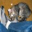

3


In [41]:
with open ('./adversarial/CW_0.2_adv_images.pickle', 'rb') as fp:
    info = pickle.load(fp)
    print(info[0])
    img1 = transforms.ToPILImage()(info[0].float())
    img2 = transforms.ToTensor()(img1)
    print(img2)
    img1.show()
with open ('./adversarial/CW_0.2_adv_label.pickle', 'rb') as fp:
    info = pickle.load(fp)
    print(info[0])